# Investigating Open Research relating to COVID-19 with spaCy
* Exploration of embeddings and concepts such as word2vec in relation to CORD-19 dataset.
* Here, I used a spaCy language model that has been trained using biomedical corpus by Allen AI (scispacy: https://allenai.github.io/scispacy/).
* I used this model to compute embeddings for each piece of text. This takes a while to compute so I precomputed them. This is uploaded using a separate dataset (`covid_with_embedding.json`).
* I also used `gensim` to obtain keywords from each piece of text for easier viewing (https://radimrehurek.com/gensim/summarization/keywords.html).
* I am particularly interested to see if there has been any research that is related to misinformation and education.
* I used a wordcloud (https://github.com/amueller/word_cloud) to provide a simple visualisation to my findings.

Install packages required

In [1]:
!pip install scispacy --quiet
!pip install spacy --quiet
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz --quiet
!pip install wordcloud --quiet

ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.


Import packages required

In [2]:
import glob
import json
import pandas as pd
import numpy as np
import scispacy
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from itertools import chain
from collections import Counter
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from pprint import pprint
from tqdm.notebook import trange, tqdm
tqdm.pandas()
%matplotlib inline

Instantiate language model

In [3]:
nlp = spacy.load("en_core_sci_md")

### Get all the JSON files and combine into a DataFrame
* Use `glob` to recursively find JSON files in the data files.

In [4]:
result = []
for filename in tqdm(glob.glob("../input/CORD-19-research-challenge/**/*.json", recursive=True)):
    with open(filename, encoding='utf-8') as f:
        json_file = json.load(f)
        
    body_texts = json_file.get("body_text", [])
    body_text = " ".join([b['text'] for b in body_texts])
    
    sections = [b['section'].strip().lower() for b in body_texts if (b['section'].strip() != "" and not b['section'].isdigit())]
    sections = list(set(sections))
    
    if len(sections) == 0:
        sections = ""
    
    sha = filename.split("/")[-1].split(".json")[0]
    
    result.append((sha, sections, body_text))

In [5]:
papers_df = pd.DataFrame(result, columns=["sha", "sections", "body_text"])
len(papers_df)

33375

### Also get the metadata csv file and combine with the above DataFrame

In [6]:
source_metadata_df = pd.read_csv("../input/CORD-19-research-challenge/metadata.csv")

In [7]:
df = pd.merge(papers_df, source_metadata_df, on="sha")

### Use `Spacy` (trained with `scispacy`) to get embeddings from `body_text`
* Use `gensim` to obtain keywords from `body_text`.
* Get from **pre-computed** embeddings (explained above).

In [8]:
df = pd.read_json("../input/cord19-embeddings-with-scispacy/covid_with_embedding.json")
df = df[['sha', 'sections', 'body_text', 'title', 'doi', 'abstract', 'body_text_embedding', 'body_text_gensim_keywords']]

### Given a query word, find the paper that has the closest vector/embedding
* Here, I use `scikit_learn`'s utility function `cosine_distances`.
* I first define a `query_word` that I would like to query. The `nlp` spaCy language object then checks if this word exists in its vocabulary.
* I use the `query_word` _misinformation_.

In [9]:
query_word = "misinformation"
query_vector = None

if query_word in nlp.vocab:
    query_vector = nlp.vocab[query_word].vector

Compute cosine distance from `query_vector`.

In [10]:
def cosine_distance_from_query(e):
    embedding = np.asarray(e)
    return cosine_distances(embedding.reshape(1, -1), query_vector.reshape(1, -1))[0][0]

df['dist_to_query_vector'] = df['body_text_embedding'].progress_apply(cosine_distance_from_query)

Get top `N=10` most rows, whose `body_text` is most similar to `query_vector`.

In [11]:
N = 10
top_N_similar_rows = df.loc[df['dist_to_query_vector'].sort_values().head(10).index]

In [12]:
top_N_similar_rows[['sha', 'body_text', 'title', 'doi', 'body_text_gensim_keywords']]

,sha,body_text,title,doi,body_text_gensim_keywords
3011,3b8d650d6325394ab80ca6c41330f625134680eb,type of psychological counseling mode in the c...,A Novel Approach of Consultation on 2019 Novel...,http://dx.doi.org/10.30773/pi.2020.0047,"[psychological counseling, structured, interve..."
6981,861f05718b673306c2044167d92bb31d68a0d9bb,The ongoing coronavirus disease 2019 (COVID-19...,Tracking online heroisation and blame in epide...,10.1016/S2468-2667(20)30033-5,"[public health, epidemic, authorities, online,..."
12090,ea0237728df0d0d6df8c9bf3623c7e696c03a7f3,"the case of quarantine due to disease, a judge...",Making State Public Health Laws Work for SARS ...,http://dx.doi.org/10.3201/eid1002.030836,"[public health, law, judicial, administrative,..."
3792,4a99bf8fae88d43868e5b8ec0fa4c1c375b951f7,HIV is a serious global epidemic causing heavy...,Stigmatization among people living with HIV in...,http://dx.doi.org/10.1111/hex.12535,"[hiv, socially, participating, negative, self,..."
2038,28c3136f729fa6b60127262e63ee74613597a1e6,In their review recently published in Critical...,Pandemic influenza: are we prepared to face ou...,http://dx.doi.org/10.1186/cc6938,"[care, professionals, risk, institutional, iss..."
11882,e5869f8b8ecda2894a0ac35dc2f50bf56f24e72f,The mass media is a critical component of resp...,Journalists’ views about reporting avian influ...,http://dx.doi.org/10.1111/j.1750-2659.2011.003...,"[journalist, publication, reports, new, health..."
5608,6bd5e8bc7dfa11b9f9d98c97a7e7b1e8ba0e5909,Sharing of preprints-scientific manuscripts th...,Preprints in medical research: Progress and pr...,http://dx.doi.org/10.1371/journal.pmed.1002563,"[preprint, researchers, journals, author, repo..."
8009,99c0958f9fa04d32dcdd13fcc01ffcb531f48950,Science influences public health decisions and...,"Plagues, Public Health, and Politics",http://dx.doi.org/10.3201/eid1011.040673,"[political, public health, vaccinate, diseases..."
10892,d2e50891500031a482f95969c3657a6ef253b22a,We conducted a survey of 928 New York City are...,Social Factors Associated with AIDS and SARS,http://dx.doi.org/10.3201/eid1111.050424,"[public, informing, sars, reported, disease, t..."
5921,71d8abeec95c4d64d23aebfb95379158d85253e3,W hen an influenza pandemic swept the globe in...,Learning from recent outbreaks to strengthen r...,http://dx.doi.org/10.5365/wpsar.2018.9.5.013,"[communicating, health, risk, public, pacific,..."


#### Some examples that explicitly discussed misinformation and/or media:
* Index 6981: _"The ongoing coronavirus disease 2019 (COVID-19) outbreak is giving rise to worldwide anxieties, rumours, and online misinformation..."_ (http://dx.doi.org/10.1016/S2468-2667(20)30033-5)
* Index 2038: _"In their review recently published in Critical Care, Anantham and coworkers outline the ethical framework that forms the basis of the professional obligations of physicians who respond to health care emergencies..."_ (http://dx.doi.org/10.1186/cc6938)
* Index 11882: _"In this study, we explored the factors that influenced journalists’ coverage of avian influenza as a model for coverage of a potential influenza pandemic..."_ (http://dx.doi.org/10.1111/j.1750-2659.2011.00319.x)

### What are they talking about? What keywords are most frequently used?
* Create a counter to see what are the top keywords used in the first `N` rows.
* Use the `wordcloud` library for a simple visualisation.

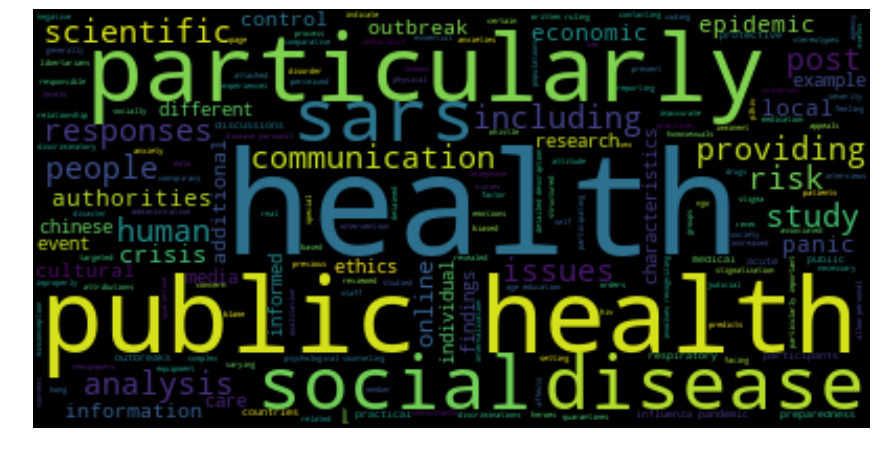

In [13]:
query_counter = Counter(chain.from_iterable(top_N_similar_rows['body_text_gensim_keywords'].apply(set).values))
query_wordcloud = WordCloud().generate_from_frequencies(query_counter)
plt.figure(figsize=(15, 8))
plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Repeat the same as above with another similarity measure other than `cosine_distances`

In [14]:
def manhattan_distance_from_query(e):
    embedding = np.asarray(e)
    return manhattan_distances(embedding.reshape(1, -1), query_vector.reshape(1, -1))[0][0]

df['man_dist_to_query_vector'] = df['body_text_embedding'].progress_apply(manhattan_distance_from_query)
top_N_similar_rows_manhattan = df.loc[df['man_dist_to_query_vector'].sort_values().head(10).index]
top_N_similar_rows_manhattan[['sha', 'body_text', 'title', 'doi', 'body_text_gensim_keywords']]

,sha,body_text,title,doi,body_text_gensim_keywords
3011,3b8d650d6325394ab80ca6c41330f625134680eb,type of psychological counseling mode in the c...,A Novel Approach of Consultation on 2019 Novel...,http://dx.doi.org/10.30773/pi.2020.0047,"[psychological counseling, structured, interve..."
12090,ea0237728df0d0d6df8c9bf3623c7e696c03a7f3,"the case of quarantine due to disease, a judge...",Making State Public Health Laws Work for SARS ...,http://dx.doi.org/10.3201/eid1002.030836,"[public health, law, judicial, administrative,..."
6981,861f05718b673306c2044167d92bb31d68a0d9bb,The ongoing coronavirus disease 2019 (COVID-19...,Tracking online heroisation and blame in epide...,10.1016/S2468-2667(20)30033-5,"[public health, epidemic, authorities, online,..."
3792,4a99bf8fae88d43868e5b8ec0fa4c1c375b951f7,HIV is a serious global epidemic causing heavy...,Stigmatization among people living with HIV in...,http://dx.doi.org/10.1111/hex.12535,"[hiv, socially, participating, negative, self,..."
10892,d2e50891500031a482f95969c3657a6ef253b22a,We conducted a survey of 928 New York City are...,Social Factors Associated with AIDS and SARS,http://dx.doi.org/10.3201/eid1111.050424,"[public, informing, sars, reported, disease, t..."
10306,c7ec0563ddbb18f183ddbd147056d8a2aca9fef2,Objectives The study aimed to qualitatively ex...,Understanding perceptions of global healthcare...,http://dx.doi.org/10.1136/bmjopen-2018-026020,"[participating, physician, healthcare, researc..."
11882,e5869f8b8ecda2894a0ac35dc2f50bf56f24e72f,The mass media is a critical component of resp...,Journalists’ views about reporting avian influ...,http://dx.doi.org/10.1111/j.1750-2659.2011.003...,"[journalist, publication, reports, new, health..."
8009,99c0958f9fa04d32dcdd13fcc01ffcb531f48950,Science influences public health decisions and...,"Plagues, Public Health, and Politics",http://dx.doi.org/10.3201/eid1011.040673,"[political, public health, vaccinate, diseases..."
5921,71d8abeec95c4d64d23aebfb95379158d85253e3,W hen an influenza pandemic swept the globe in...,Learning from recent outbreaks to strengthen r...,http://dx.doi.org/10.5365/wpsar.2018.9.5.013,"[communicating, health, risk, public, pacific,..."
2038,28c3136f729fa6b60127262e63ee74613597a1e6,In their review recently published in Critical...,Pandemic influenza: are we prepared to face ou...,http://dx.doi.org/10.1186/cc6938,"[care, professionals, risk, institutional, iss..."


### The top 10 most similar rows are mostly similar
* Although the following row wasn't present previously:
* Index 10306: _"The study aimed to qualitatively examine the perspectives of US-based physicians and academic global health programme leaders on how global health work shapes their viewpoints, values and healthcare practices back in the USA..._" (http://dx.doi.org/10.1136/bmjopen-2018-026020)

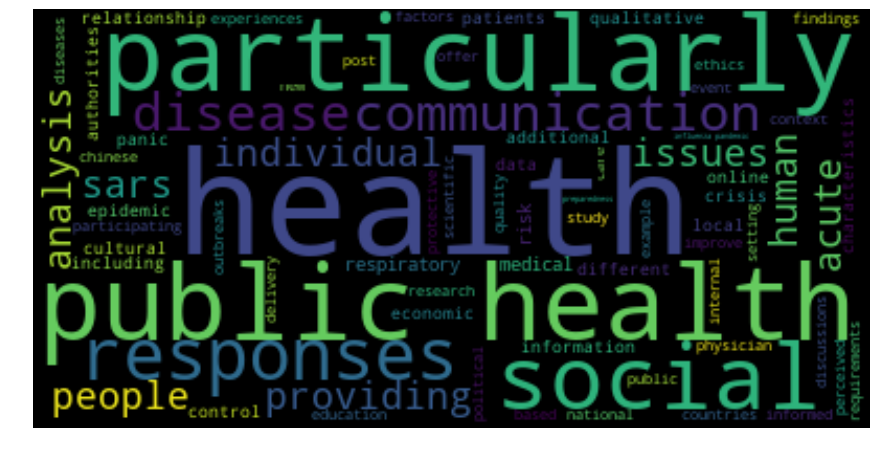

In [15]:
query_counter = Counter(chain.from_iterable(top_N_similar_rows_manhattan['body_text_gensim_keywords'].apply(set).values))
query_wordcloud = WordCloud().generate_from_frequencies(query_counter)
plt.figure(figsize=(15, 8))
plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Discussion
* From the word cloud, as expected, _health_ and _public health_ appeared very often, but words like _communication_, _information_ and _online_ also have significant frequency.
* For a word/phrase whose vocabulary not in the language model trained by `scispacy`, it is skipped over and does not contribute to the sentence embedding. This might be because of spelling errors which are not checked and might be common. A more sophisticated method like creating sentence embeddings using `BERT` can be used, or simply using another external package to correct these spelling mistakes.
* For each sentence, I took the average word embedding of the words in the sentence to form its sentence embedding. There might be other methods to aggregate these word embeddings.
* I also used `cosine_distances` to quantity how close two vectors are. Other measures can also be used.